# Collaborative filtering on Google Analytics data

This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

In [1]:
import os
PROJECT = "cloud-training-demos" # REPLACE WITH YOUR PROJECT ID
BUCKET = "cloud-training-demos-ml" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.13"

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

1.13.1


## Create raw dataset
<p>
For collaborative filtering, we don't need to know anything about either the users or the content. Essentially, all we need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, we are working with newspaper articles. The company doesn't ask their users to rate the articles. However, we can use the time-spent on the page as a proxy for rating.
<p>
Normally, we would also add a time filter to this ("latest 7 days"), but our dataset is itself limited to a few days.

In [3]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

sql = """
WITH CTE_visitor_page_content AS (
    SELECT
        # Schema: https://support.google.com/analytics/answer/3437719?hl=en
        # For a completely unique visit-session ID, we combine combination of fullVisitorId and visitNumber:
        CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"
GROUP BY   
        fullVisitorId,
        visitNumber,
        latestContentId,
        hits.time )
-- Aggregate web stats
SELECT   
    visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    visitorId, 
    latestContentId
HAVING 
    session_duration > 0
"""

df = bq.query(sql).to_dataframe()
df.head()

visitorId  contentId  session_duration
0  1000148716229112932-150  299913879             24501
1  1000148716229112932-150  299912101             48539
2  1000163602560555666-481  299918278             51196
3  1000163602560555666-478  298888038             30383
4  1000163602560555666-481  299912085             20331

In [4]:
stats = df.describe()
stats

session_duration
count      2.843080e+05
mean       1.247931e+05
std        2.311622e+05
min        1.000000e+00
25%        1.607200e+04
50%        5.627900e+04
75%        1.271780e+05
max        7.690598e+06

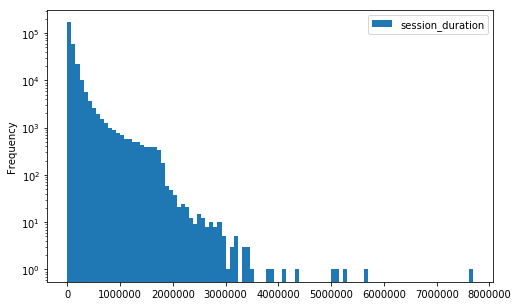

In [5]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

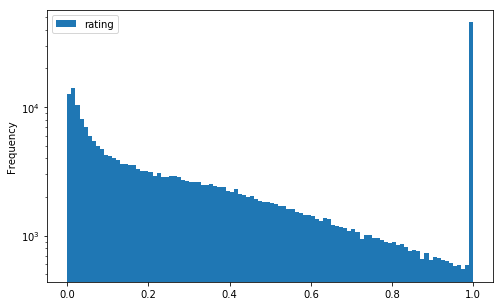

In [6]:
# The rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc["50%", "session_duration"]
df["rating"] = 0.3 * df["session_duration"] / median
df.loc[df["rating"] > 1, "rating"] = 1
df[["rating"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

In [7]:
del df["session_duration"]

In [8]:
%%bash
rm -rf data
mkdir data

In [9]:
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)

In [10]:
!head data/collab_raw.csv

1000148716229112932-150,299913879,0.1306046660388422
1000148716229112932-150,299912101,0.25874127116686507
1000163602560555666-481,299918278,0.27290463583219315
1000163602560555666-478,298888038,0.1619591677179765
1000163602560555666-481,299912085,0.10837612608610672
1000163602560555666-478,299772450,0.027628422679862825
1000196974485173657-270,299925086,0.005362568631283427
1000196974485173657-271,299950903,0.09858384121963787
1000196974485173657-273,299965875,0.15314771051369072
1000196974485173657-274,299972194,0.3221485811759271


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so we need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> We will need to save the above mapping to a file because at prediction time, we'll need to know how to map the contentId in the table above to the itemId.
<li> We'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [11]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
    with open(filename, 'w') as ofp:
        value_to_id = {value:idx for idx, value in enumerate(values.unique())}
        for value, idx in value_to_id.items():
            ofp.write("{},{}\n".format(value, idx))
    return value_to_id

df = pd.read_csv(filepath_or_buffer = "data/collab_raw.csv",
                 header = None,
                 names = ["visitorId", "contentId", "rating"],
                dtype = {"visitorId": str, "contentId": str, "rating": np.float})
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)
user_mapping = create_mapping(df["visitorId"], "data/users.csv")
item_mapping = create_mapping(df["contentId"], "data/items.csv")

In [12]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
1000148716229112932-150,299913879,0.1306046660388422
1000148716229112932-150,299912101,0.2587412711668651
1000163602560555666-481,299918278,0.27290463583219315

==> data/items.csv <==
270101894,5598
123146162,5133
297753966,1386

==> data/users.csv <==
5920254686919747111-226,65388
2877197600805658919-1495,13239
2969314934247982067-1,85239


In [13]:
df["userId"] = df["visitorId"].map(user_mapping.get)
df["itemId"] = df["contentId"].map(item_mapping.get)

In [14]:
mapped_df = df[["userId", "itemId", "rating"]]
mapped_df.to_csv(path_or_buf = "data/collab_mapped.csv", index = False, header = False)
mapped_df.head()

userId  itemId    rating
0       0       0  0.130605
1       0       1  0.258741
2       1       2  0.272905
3       2       3  0.161959
4       1       4  0.108376

### Creating rows and columns datasets

In [15]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv(filepath_or_buffer = "data/collab_mapped.csv", header = None, names = ["userId", "itemId", "rating"])
mapped_df.head()

userId  itemId    rating
0       0       0  0.130605
1       0       1  0.258741
2       1       2  0.272905
3       2       3  0.161959
4       1       4  0.108376

In [16]:
NITEMS = np.max(mapped_df["itemId"]) + 1
NUSERS = np.max(mapped_df["userId"]) + 1
mapped_df["rating"] = np.round(mapped_df["rating"].values, 2)
print("{} items, {} users, {} interactions".format( NITEMS, NUSERS, len(mapped_df) ))

5667 items, 120954 users, 284308 interactions


In [ ]:
grouped_by_items = mapped_df.groupby("itemId")
iter = 0
for item, grouped in grouped_by_items:
    print(item, grouped["userId"].values, grouped["rating"].values)
    iter = iter + 1
    if iter > 5:
        break

In [ ]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby("itemId")
with tf.python_io.TFRecordWriter("data/users_for_item") as ofp:
    for item, grouped in grouped_by_items:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [item])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["userId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [20]:
grouped_by_users = mapped_df.groupby("userId")
with tf.python_io.TFRecordWriter("data/items_for_user") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [21]:
!ls -lrt data

total 31908
-rw-r--r-- 1 jupyter jupyter 13152765 Jul 31 20:41 collab_raw.csv
-rw-r--r-- 1 jupyter jupyter  2134511 Jul 31 20:41 users.csv
-rw-r--r-- 1 jupyter jupyter    82947 Jul 31 20:41 items.csv
-rw-r--r-- 1 jupyter jupyter  7812739 Jul 31 20:41 collab_mapped.csv
-rw-r--r-- 1 jupyter jupyter  2252828 Jul 31 20:41 users_for_item
-rw-r--r-- 1 jupyter jupyter  7217822 Jul 31 20:41 items_for_user


To summarize, we created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/master/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, we write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, we use tf.contrib.learn.Experiment to handle the training loop.

In [22]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
    def decode_example(protos, vocab_size):
        features = {
            "key": tf.FixedLenFeature(shape = [1], dtype = tf.int64),
            "indices": tf.VarLenFeature(dtype = tf.int64),
            "values": tf.VarLenFeature(dtype = tf.float32)}
        parsed_features = tf.parse_single_example(serialized = protos, features = features)
        values = tf.sparse_merge(sp_ids = parsed_features["indices"], sp_values = parsed_features["values"], vocab_size = vocab_size)
        # Save key to remap after batching
        # This is a temporary workaround to assign correct row numbers in each batch.
        # You can ignore details of this part and remap_keys().
        key = parsed_features["key"]
        decoded_sparse_tensor = tf.SparseTensor(indices = tf.concat(values = [values.indices, [key]], axis = 0), 
                                                values = tf.concat(values = [values.values, [0.0]], axis = 0), 
                                                dense_shape = values.dense_shape)
        return decoded_sparse_tensor
  
  
    def remap_keys(sparse_tensor):
        # Current indices of our SparseTensor that we need to fix
        bad_indices = sparse_tensor.indices # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)
        # Current values of our SparseTensor that we need to fix
        bad_values = sparse_tensor.values # shape = (current_batch_size * (number_of_items/users[i] + 1),)

        # Since batch is ordered, the last value for a batch index is the user
        # Find where the batch index chages to extract the user rows
        # 1 where user, else 0
        user_mask = tf.concat(values = [bad_indices[1:,0] - bad_indices[:-1,0], tf.constant(value = [1], dtype = tf.int64)], axis = 0) # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)

        # Mask out the user rows from the values
        good_values = tf.boolean_mask(tensor = bad_values, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        item_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        user_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 1))[:, 1] # shape = (current_batch_size,)

        good_user_indices = tf.gather(params = user_indices, indices = item_indices[:,0]) # shape = (current_batch_size * number_of_items/users[i],)

        # User and item indices are rank 1, need to make rank 1 to concat
        good_user_indices_expanded = tf.expand_dims(input = good_user_indices, axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_item_indices_expanded = tf.expand_dims(input = item_indices[:, 1], axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_indices = tf.concat(values = [good_user_indices_expanded, good_item_indices_expanded], axis = 1) # shape = (current_batch_size * number_of_items/users[i], 2)

        remapped_sparse_tensor = tf.SparseTensor(indices = good_indices, values = good_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor

    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(filename = os.path.join(args["input_path"], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(map_func = lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(count = num_epochs)
        dataset = dataset.batch(batch_size = args["batch_size"])
        dataset = dataset.map(map_func = lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
  
    def _input_fn():
        features = {
            WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords("items_for_user", args["nitems"]),
            WALSMatrixFactorization.INPUT_COLS: parse_tfrecords("users_for_item", args["nusers"]),
            WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None

    return _input_fn

This code is helpful in developing the input function. You don't need it in production.

In [24]:
def try_out():
    with tf.Session() as sess:
        fn = read_dataset(
            mode = tf.estimator.ModeKeys.EVAL, 
            args = {"input_path": "data", "batch_size": 4, "nitems": NITEMS, "nusers": NUSERS})
        feats, _ = fn()
        
        print(feats["input_rows"].eval())
        print(feats["input_rows"].eval())

try_out()

SparseTensorValue(indices=array([[   0,    0],
       [   0, 3522],
       [   0, 3583],
       [   1,    1],
       [   1, 2359],
       [   1, 3133],
       [   1, 4864],
       [   1, 4901],
       [   1, 4906],
       [   1, 5667],
       [   2,    2],
       [   3,    2],
       [   3, 1467]]), values=array([0.23, 0.05, 0.18, 1.  , 0.11, 0.55, 0.3 , 0.72, 0.46, 0.3 , 0.25,
       0.17, 0.13], dtype=float32), dense_shape=array([   4, 5721]))
SparseTensorValue(indices=array([[   4,    3],
       [   5,    4],
       [   5, 5042],
       [   5, 5525],
       [   5, 5553],
       [   6,    5],
       [   7,    5]]), values=array([0.05, 0.95, 0.63, 1.  , 0.16, 1.  , 0.48], dtype=float32), dense_shape=array([   4, 5721]))


In [25]:
def find_top_k(user, item_factors, k):
    all_items = tf.matmul(a = tf.expand_dims(input = user, axis = 0), b = tf.transpose(a = item_factors))
    topk = tf.nn.top_k(input = all_items, k = k)
    return tf.cast(x = topk.indices, dtype = tf.int64)
    
def batch_predict(args):
    import numpy as np
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        # This is how you would get the row factors for out-of-vocab user data
        # row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        # user_factors = tf.convert_to_tensor(np.array(row_factors))

        # But for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(value = estimator.get_row_factors()[0]) # (nusers, nembeds)
        # In either case, we have to assume catalog doesn"t change, so col_factors are read in
        item_factors = tf.convert_to_tensor(value = estimator.get_col_factors()[0])# (nitems, nembeds)

        # For each user, find the top K items
        topk = tf.squeeze(input = tf.map_fn(fn = lambda user: find_top_k(user, item_factors, args["topk"]), elems = user_factors, dtype = tf.int64))
        with file_io.FileIO(os.path.join(args["output_dir"], "batch_pred.txt"), mode = 'w') as f:
            for best_items_for_user in topk.eval():
                f.write(",".join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args["num_epochs"] * args["nusers"]) / args["batch_size"])
    steps_in_epoch = int(0.5 + args["nusers"] / args["batch_size"])
    print("Will train for {} steps, evaluating once every {} steps".format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows = args["nusers"], 
                num_cols = args["nitems"],
                embedding_dimension = args["n_embeds"],
                model_dir = args["output_dir"]),
            train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps = train_steps,
            eval_steps = 1,
            min_eval_frequency = steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn = experiment_fn, output_dir = args["output_dir"])
    
    batch_predict(args)

In [26]:
import shutil
shutil.rmtree(path = "wals_trained", ignore_errors=True)
train_and_evaluate({
    "output_dir": "wals_trained",
    "input_path": "data/",
    "num_epochs": 0.05,
    "nitems": NITEMS,
    "nusers": NUSERS,

    "batch_size": 512,
    "n_embeds": 10,
    "topk": 3
  })

Will train for 8 steps, evaluating once every 162 steps
Instructions for updating:
Use tf.estimator.train_and_evaluate.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_task_id': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb220516da0>, '_save_checkpoints_steps': None, '_task_type': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_environment': 'local', '_eval_distribute': None, '_session_config': None, '_train_distribute': None, '_evaluation_master': '', '_num_worker_replicas': 0,

In [27]:
!ls wals_trained

batch_pred.txt			  model.ckpt-0.index
checkpoint			  model.ckpt-0.meta
eval				  model.ckpt-8.data-00000-of-00001
events.out.tfevents.1564605788.r  model.ckpt-8.index
graph.pbtxt			  model.ckpt-8.meta
model.ckpt-0.data-00000-of-00001


In [28]:
!head wals_trained/batch_pred.txt

284,5609,36
284,2754,42
284,3168,534
2621,5528,2694
4409,5295,343
5161,3267,3369
5479,1335,55
5479,1335,55
4414,284,5572
284,241,2359


## Run as a Python module

Let's run it as Python module for just a few steps.

In [33]:
os.environ["NITEMS"] = str(NITEMS)
os.environ["NUSERS"] = str(NUSERS)

In [ ]:
%%bash
rm -rf wals.tar.gz wals_trained
gcloud ai-platform local train \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    -- \
    --output_dir=${PWD}/wals_trained \
    --input_path=${PWD}/data \
    --num_epochs=0.01 --nitems=${NITEMS} --nusers=${NUSERS} \
    --job-dir=./tmp

## Run on Cloud

In [ ]:
%%bash
gcloud storage cp data/* gs://${BUCKET}/wals/data

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gcloud storage rm --recursive --continue-on-error $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --input_path=gs://${BUCKET}/wals/data \
    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} 

This took <b>10 minutes</b> for me.

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. We'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [36]:
def get_factors(args):
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        row_factors = estimator.get_row_factors()[0]
        col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [41]:
args = {
    "output_dir": "gs://{}/wals/model_trained".format(BUCKET),
    "nitems": NITEMS,
    "nusers": NUSERS,
    "n_embeds": 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_environment': 'local', '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 0, '_session_config': None, '_task_type': None, '_eval_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_master': '', '_log_step_count_steps': 100, '_model_dir': 'gs://qwiklabs-gcp-cbc8684b07fc2dbd-bucket/wals/model_trained', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4bd8302f28>, '_device_fn': None, '_keep_checkpoint_max': 5, '_task_id': 0, '_evaluation_master': '', '_save_checkpoints_steps': None, '_protocol': None, '_train_distribute': None, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': None, '_num_ps_replicas': 0}
[[ 3.3451824e-06 -1.1986867e-05  4.8447573e-06 -1.5209486e-05
  -1.7004859e-07  1.1976428e-05  9.8887876e-06  7.2386983e-06
  -7.0237149e-07 -7.9796819e-06]
 [-2.5300323e-03  1.4055537e

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

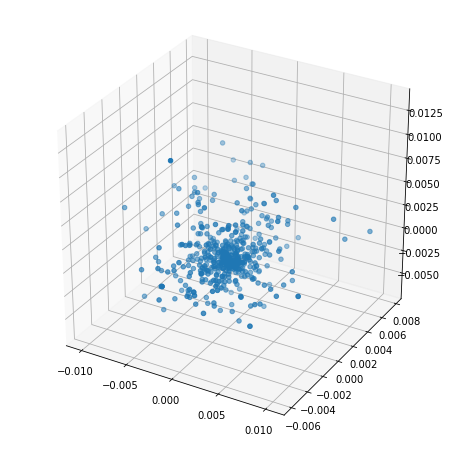

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(user_embeddings)
user_embeddings_pca = pca.transform(user_embeddings)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

<pre>
# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>